# Amplitude model with `ampform-dpd`

PWA study on $p \gamma \to \Lambda K^+ \pi^0$.
We formulate the helicity amplitude model symbolically using AmpForm-DPD here.

In [1]:
import logging
import os
import warnings
from collections import defaultdict
from fractions import Fraction
from textwrap import dedent

import ampform
import graphviz
import ipywidgets as w
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import qrules
import sympy as sp
from ampform.dynamics.builder import RelativisticBreitWignerBuilder
from ampform.io import improve_latex_rendering
from ampform_dpd import DalitzPlotDecompositionBuilder
from ampform_dpd.adapter.qrules import normalize_state_ids, to_three_body_decay
from ampform_dpd.decay import DecayNode, ThreeBodyDecayChain
from ampform_dpd.dynamics.builder import create_mass_symbol, get_mandelstam_s
from ampform_dpd.io import aslatex
from IPython.display import SVG, Image, Markdown, Math, display
from qrules.particle import Particle, Spin, create_particle, load_pdg
from tensorwaves.data import SympyDataTransformer
from tensorwaves.function.sympy import create_parametrized_function

STATIC_PAGE = "EXECUTE_NB" in os.environ

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.disable(logging.WARNING)
warnings.filterwarnings("ignore")

improve_latex_rendering()
particle_db = load_pdg()

## Decay definition

### Particle definitions

In [2]:
def generate_markdown_table(particles: list[str]):
    src = dedent(r"""
    | Particle | Name | PID | $J^{PC} (I^G)$ | $I_3$ | $M$ | $\Gamma$ | $Q$ | $S$ | $B$ |
    | :------- |------|-----|----------------|-------|-----|----------|-----|-----|-----|
    """)
    for name in particles:
        p = particle_db[name]
        src += f"| ${p.latex}$ | `{p.name}` | {p.pid} | {jpc_ig(p)} | {i_3(p)} |  {p.mass:.3g}| {p.width:g} | {p.charge} |{p.strangeness} | {p.baryon_number}|\n"
    return src


def jpc_ig(particle: Particle) -> str:
    j = format_fraction(particle.spin)
    p = format_parity(particle.parity)
    c = format_parity(particle.c_parity)
    if particle.isospin is None:
        return f"${j}^{{{p}{c}}}$"
    i = format_fraction(particle.isospin.magnitude)
    g = format_parity(particle.g_parity)
    return rf"${j}^{{{p}{c}}} \; ({i}^{{{g}}})$"


def i_3(particle: Particle) -> str:
    if particle.isospin is None:
        return "N/A"
    return f"${format_fraction(particle.isospin.projection)}$"


def format_fraction(value: float) -> str:
    value = Fraction(value)
    if value.denominator == 1:
        return str(value.numerator)
    return rf"\frac{{{value.numerator}}}{{{value.denominator}}}"


def format_parity(parity: int | None) -> str:
    if parity is None:
        return " "
    if parity == -1:
        return "-"
    if parity == 1:
        return "+"
    raise NotImplementedError


particles = ["Lambda", "K+", "pi0", "gamma", "p"]
src = generate_markdown_table(particles)
Markdown(src)


| Particle | Name | PID | $J^{PC} (I^G)$ | $I_3$ | $M$ | $\Gamma$ | $Q$ | $S$ | $B$ |
| :------- |------|-----|----------------|-------|-----|----------|-----|-----|-----|
| $\Lambda$ | `Lambda` | 3122 | $\frac{1}{2}^{+ } \; (0^{ })$ | $0$ |  1.12| 2.515e-15 | 0 |-1 | 1|
| $K^{+}$ | `K+` | 321 | $0^{- } \; (\frac{1}{2}^{ })$ | $\frac{1}{2}$ |  0.494| 5.317e-17 | 1 |1 | 0|
| $\pi^{0}$ | `pi0` | 111 | $0^{-+} \; (1^{-})$ | $0$ |  0.135| 7.81e-09 | 0 |0 | 0|
| $\gamma$ | `gamma` | 22 | $1^{--}$ | N/A |  0| 0 | 0 |0 | 0|
| $p$ | `p` | 2212 | $\frac{1}{2}^{+ } \; (\frac{1}{2}^{ })$ | $\frac{1}{2}$ |  0.938| 0 | 1 |0 | 1|


In the table above, PID is the PDG ID from PDG particle numbering scheme,
$J$ is the spin, $P$ is the parity, $C$ is the C parity, $I$ is the isospin (magnitude), $G$ is the G parity.
$I_3$ is the isospin projection (or the 3rd component),
$M$ is the mass,
$\Gamma$ is the width,
$Q$ is the charge,
$S$ is the strangeness number,
and $B$ is the baryon number.

### Initial state definition

Mass for $p \gamma$ system

In [3]:
E_lab_gamma = 8.5
m_proton = 0.938
m_0 = np.sqrt(2 * E_lab_gamma * m_proton + m_proton**2)
m_eta = 0.548
m_pi = 0.135
m_0

np.float64(4.101931740046389)

Add custom particle $p \gamma$

In [4]:
pgamma1 = Particle(
    name="pgamma1",
    latex=r"p\gamma (s1/2)",
    spin=0.5,
    mass=m_0,
    charge=1,
    isospin=Spin(1 / 2, +1 / 2),
    baryon_number=1,
    parity=-1,
    pid=99990,
)
pgamma2 = create_particle(
    template_particle=pgamma1,
    name="pgamma2",
    latex=R"p\gamma (s3/2)",
    spin=1.5,
    pid=pgamma1.pid + 1,
)
particle_db.update([pgamma1, pgamma2])

### Generate transitions

For simplicity, we use the initial state $p \gamma$ (with spin-$\frac{1}{2}$), 
and set the allowed interaction type to be strong only,
the formalism is selected to be helicity formalism instead of canonical.

:::{seealso}
[Helicity versus canonical](https://ampform.readthedocs.io/stable/usage/helicity/formalism.html)
:::

In [5]:
reaction = qrules.generate_transitions(
    initial_state=("pgamma1"),
    final_state=["Lambda", "K+", "pi0"],
    allowed_interaction_types=["strong"],
    formalism="helicity",
    particle_db=particle_db,
    max_angular_momentum=4,
    max_spin_magnitude=4,
    mass_conservation_factor=0,
)
reaction = normalize_state_ids(reaction)

Propagating quantum numbers:   0%|          | 0/12 [00:00<?, ?it/s]

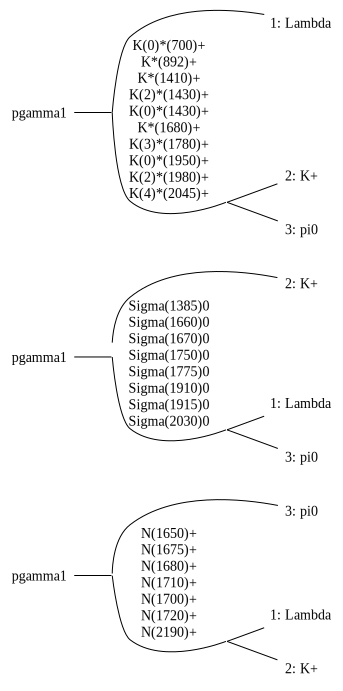

In [6]:
dot = qrules.io.asdot(reaction, collapse_graphs=True)
graphviz.Source(dot)

In [7]:
decay = to_three_body_decay(reaction.transitions)
Math(aslatex(decay, with_jp=True))

<IPython.core.display.Math object>

## Formulate amplitude model

In [8]:
model_builder = ampform.get_builder(reaction)
model_builder.config.scalar_initial_state_mass = True
model_builder.config.stable_final_state_ids = list(reaction.final_state)
bw_builder = RelativisticBreitWignerBuilder(
    energy_dependent_width=False,
    form_factor=False,
)
for name in reaction.get_intermediate_particles().names:
    model_builder.dynamics.assign(name, bw_builder)
model = model_builder.formulate()

In [9]:
model.intensity

PoolSum(Abs(A^12[m0, m1, m2, m3] + A^13[m0, m1, m2, m3] + A^23[m0, m1, m2, m3])**2, (m0, (1/2, -1/2)), (m1, (1/2, -1/2)), (m2, (0,)), (m3, (0,)))

In [10]:
def formulate_breit_wigner(
    decay: ThreeBodyDecayChain,
) -> tuple[sp.Expr, dict[sp.Symbol, complex | float]]:
    decay_node = decay.decay_node
    s = get_mandelstam_s(decay_node)
    parameter_defaults = {}
    breit_wigner, new_pars = _create_breit_wigner(s, decay_node)
    parameter_defaults.update(new_pars)
    return (
        breit_wigner,
        parameter_defaults,
    )


def _create_breit_wigner(
    s: sp.Symbol, isobar: DecayNode
) -> tuple[sp.Expr, dict[sp.Symbol, complex | float]]:
    mass = create_mass_symbol(isobar.parent)
    width = sp.Symbol(Rf"\Gamma_{{{isobar.parent.latex}}}", nonnegative=True)
    breit_wigner_expr = (mass * width) / (mass**2 - s - width * mass * sp.I)
    parameter_defaults: dict[sp.Symbol, complex | float] = {
        mass: isobar.parent.mass,
        width: isobar.parent.width,
    }
    return breit_wigner_expr, parameter_defaults

In [11]:
model_builder = DalitzPlotDecompositionBuilder(decay)
for chain in model_builder.decay.chains:
    model_builder.dynamics_choices.register_builder(chain, formulate_breit_wigner)
model = model_builder.formulate(reference_subsystem=1)

In [12]:
model.intensity

PoolSum(Abs(PoolSum(A^1[\lambda_0^{\prime}, \lambda_1^{\prime}, \lambda_2^{\prime}, \lambda_3^{\prime}]*WignerD(1/2, \lambda_1^{\prime}, lambda1, 0, \zeta^1_{1(1)}, 0)*WignerD(1/2, lambda0, \lambda_0^{\prime}, 0, \zeta^0_{1(1)}, 0) + A^2[\lambda_0^{\prime}, \lambda_1^{\prime}, \lambda_2^{\prime}, \lambda_3^{\prime}]*WignerD(1/2, \lambda_1^{\prime}, lambda1, 0, \zeta^1_{2(1)}, 0)*WignerD(1/2, lambda0, \lambda_0^{\prime}, 0, \zeta^0_{2(1)}, 0) + A^3[\lambda_0^{\prime}, \lambda_1^{\prime}, \lambda_2^{\prime}, \lambda_3^{\prime}]*WignerD(1/2, \lambda_1^{\prime}, lambda1, 0, \zeta^1_{3(1)}, 0)*WignerD(1/2, lambda0, \lambda_0^{\prime}, 0, \zeta^0_{3(1)}, 0), (\lambda_0^{\prime}, (-1/2, 1/2)), (\lambda_1^{\prime}, (-1/2, 1/2)), (\lambda_2^{\prime}, (0,)), (\lambda_3^{\prime}, (0,))))**2, (lambda0, (-1/2, 1/2)), (lambda1, (-1/2, 1/2)), (lambda2, (0,)), (lambda3, (0,)))

The first term in the amplitude model:

In [13]:
(symbol, expr), *_ = model.amplitudes.items()
Math(aslatex({symbol: expr}, terms_per_line=1))

<IPython.core.display.Math object>

In [14]:
if STATIC_PAGE:
    src = aslatex(model.parameter_defaults)
    display(Math(src))

In [15]:
Math(aslatex(model.variables))

<IPython.core.display.Math object>

## Visualization

In [16]:
unfolded_expression = model.full_expression.doit()
intensity_func = create_parametrized_function(
    expression=unfolded_expression,
    parameters=model.parameter_defaults,
    backend="jax",
)

In [17]:
i, j = 3, 1
(k,) = {1, 2, 3} - {i, j}
σk, σk_expr = list(model.invariants.items())[k - 1]
Math(aslatex({σk: σk_expr}))

<IPython.core.display.Math object>

In [18]:
resolution = 1_000
m = sorted(model.masses, key=str)
x_min = float(((m[j] + m[k]) ** 2).xreplace(model.masses))
x_max = float(((m[0] - m[i]) ** 2).xreplace(model.masses))
y_min = float(((m[i] + m[k]) ** 2).xreplace(model.masses))
y_max = float(((m[0] - m[j]) ** 2).xreplace(model.masses))
x_diff = x_max - x_min
y_diff = y_max - y_min
x_min -= 0.05 * x_diff
x_max += 0.05 * x_diff
y_min -= 0.05 * y_diff
y_max += 0.05 * y_diff
X, Y = jnp.meshgrid(
    jnp.linspace(x_min, x_max, num=resolution),
    jnp.linspace(y_min, y_max, num=resolution),
)

In [19]:
definitions = dict(model.variables)
definitions[σk] = σk_expr
definitions = {
    symbol: expr.xreplace(definitions).xreplace(model.masses)
    for symbol, expr in definitions.items()
}

data_transformer = SympyDataTransformer.from_sympy(definitions, backend="jax")
dalitz_data = {
    f"sigma{i}": X,
    f"sigma{j}": Y,
}
dalitz_data.update(data_transformer(dalitz_data))

In [20]:
resonances = defaultdict(set)
for transition in reaction.transitions:
    topology = transition.topology
    top_decay_products = topology.get_edge_ids_outgoing_from_node(0)
    (resonance_id, resonance), *_ = transition.intermediate_states.items()
    recoil_id, *_ = top_decay_products - {resonance_id}
    resonances[recoil_id].add(resonance.particle)
resonances = {k: sorted(v, key=lambda p: p.mass) for k, v in resonances.items()}
{k: [p.name for p in v] for k, v in resonances.items()}

{1: ['K(0)*(700)+',
  'K*(892)+',
  'K*(1410)+',
  'K(2)*(1430)+',
  'K(0)*(1430)+',
  'K*(1680)+',
  'K(3)*(1780)+',
  'K(0)*(1950)+',
  'K(2)*(1980)+',
  'K(4)*(2045)+'],
 2: ['Sigma(1385)0',
  'Sigma(1660)0',
  'Sigma(1670)0',
  'Sigma(1750)0',
  'Sigma(1775)0',
  'Sigma(1910)0',
  'Sigma(1915)0',
  'Sigma(2030)0'],
 3: ['N(1650)+',
  'N(1675)+',
  'N(1680)+',
  'N(1710)+',
  'N(1720)+',
  'N(1700)+',
  'N(2190)+']}

In [21]:
sliders = {}
categorized_sliders_m = defaultdict(list)
categorized_sliders_gamma = defaultdict(list)
categorized_cphi_pair = defaultdict(list)
couplings_name_root = R"\mathcal{H}^\mathrm{decay}"

for symbol, value in model.parameter_defaults.items():
    if symbol.name.startswith(R"\Gamma_{"):
        slider = w.FloatSlider(
            description=Rf"\({sp.latex(symbol)}\)",
            min=0.0,
            max=1.0,
            step=0.01,
            value=value,
            continuous_update=False,
        )
        sliders[symbol.name] = slider
        if symbol.name.startswith(R"\Gamma_{K"):
            categorized_sliders_gamma[1].append(slider)
        elif symbol.name.startswith(R"\Gamma_{\S"):
            categorized_sliders_gamma[2].append(slider)
        elif symbol.name.startswith(R"\Gamma_{N"):
            categorized_sliders_gamma[3].append(slider)

    if symbol.name.startswith("m_{"):
        slider = w.FloatSlider(
            description=Rf"\({sp.latex(symbol)}\)",
            min=0.63,
            max=4,
            step=0.01,
            value=value,
            continuous_update=False,
        )
        sliders[symbol.name] = slider
        if symbol.name.startswith("m_{K"):
            categorized_sliders_m[1].append(slider)
        elif symbol.name.startswith(R"m_{\S"):
            categorized_sliders_m[2].append(slider)
        elif symbol.name.startswith("m_{N"):
            categorized_sliders_m[3].append(slider)

    if symbol.name.startswith(couplings_name_root):
        c_latex = sp.latex(symbol)
        phi_latex = c_latex.replace(couplings_name_root, R"\phi", 1)

        slider_c = w.FloatSlider(
            description=Rf"\({c_latex}\)",
            min=0,
            max=10,
            step=0.01,
            value=abs(value),
            continuous_update=False,
        )
        slider_phi = w.FloatSlider(
            description=Rf"\({phi_latex}\)",
            min=-np.pi,
            max=+np.pi,
            step=0.01,
            value=np.angle(value),
            continuous_update=False,
        )

        sliders[symbol.name] = slider_c
        sliders[symbol.name.replace(couplings_name_root, "phi", 1)] = slider_phi

        cphi_hbox = w.HBox([slider_c, slider_phi])
        if "Sigma" in symbol.name:
            categorized_cphi_pair[2].append(cphi_hbox)
        elif "N" in symbol.name:
            categorized_cphi_pair[3].append(cphi_hbox)
        else:
            categorized_cphi_pair[1].append(cphi_hbox)


assert len(categorized_sliders_gamma) == 3
assert len(categorized_sliders_m) == 3
assert len(categorized_cphi_pair) == 3

subtabs = {}
for recoild_id, resonance_list in resonances.items():
    subtabs[recoild_id] = []
    for particle in resonance_list:
        m_sliders = [
            slider
            for slider in categorized_sliders_m[recoild_id]
            if particle.latex in slider.description
        ]
        gamma_sliders = [
            slider
            for slider in categorized_sliders_gamma[recoild_id]
            if particle.latex in slider.description
        ]
        cphi_pairs = [
            hbox
            for hbox in categorized_cphi_pair[recoild_id]
            if particle.latex in hbox.children[0].description
        ]
        pole_pair = w.HBox(m_sliders + gamma_sliders)
        resonance_tab = w.VBox([pole_pair, *cphi_pairs])
        subtabs[recoild_id].append(resonance_tab)
assert len(subtabs) == 3

main_tabs = []
for recoild_id, slider_boxes in subtabs.items():
    sub_tab_widget = w.Tab(children=slider_boxes)
    for i, particle in enumerate(resonances[recoild_id]):
        sub_tab_widget.set_title(i, particle.name)

    main_tabs.append(sub_tab_widget)

UI = w.Tab(children=main_tabs, titles=("K*", "Σ*", "N*"))

In [22]:
def insert_phi(parameters: dict) -> dict:
    updated_parameters = {}
    for key, value in parameters.items():
        if key.startswith("phi"):
            continue
        if key.startswith(couplings_name_root):
            phi_key = key.replace(couplings_name_root, "phi")
            if phi_key in parameters:
                phi = parameters[phi_key]
                value *= np.exp(1j * phi)  # noqa:PLW2901
        updated_parameters[key] = value
    return updated_parameters

In [23]:
%matplotlib widget

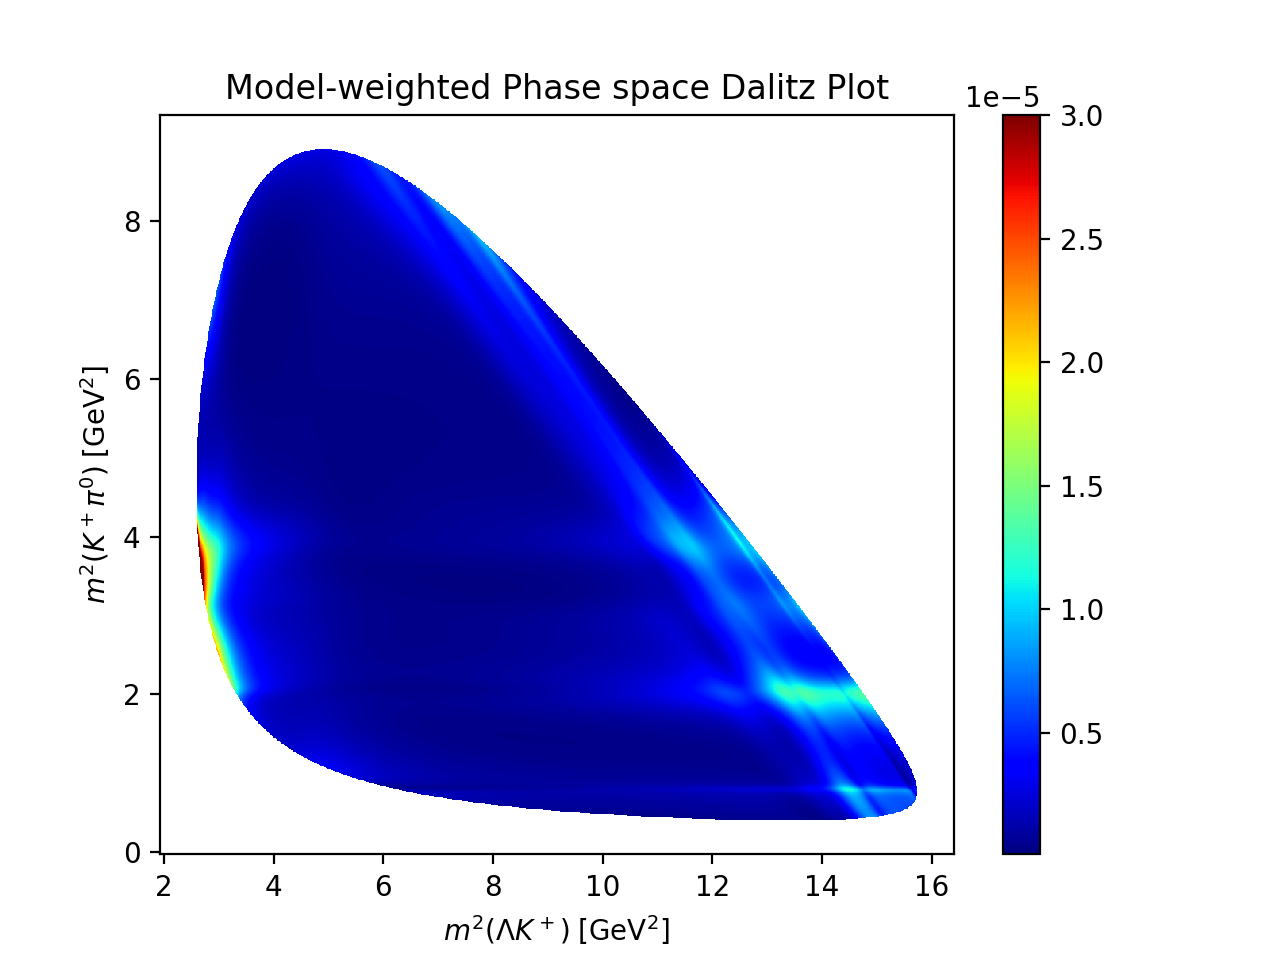

In [24]:
fig_2d, ax_2d = plt.subplots(dpi=200)
ax_2d.set_title("Model-weighted Phase space Dalitz Plot")
ax_2d.set_xlabel(R"$m^2(\Lambda K^+)\;\left[\mathrm{GeV}^2\right]$")
ax_2d.set_ylabel(R"$m^2(K^+ \pi^0)\;\left[\mathrm{GeV}^2\right]$")
fig_2d.canvas.toolbar_visible = False
fig_2d.canvas.header_visible = False
fig_2d.canvas.footer_visible = False

mesh = None


def update_dalitz_plot(**parameters):
    global mesh
    parameters = insert_phi(parameters)
    intensity_func.update_parameters(parameters)
    intensities = intensity_func(dalitz_data)  # z
    intensities /= jnp.nansum(intensities)  # normalization
    if mesh is None:
        mesh = ax_2d.pcolormesh(X, Y, intensities, cmap="jet", vmax=3e-5)
    else:
        mesh.set_array(intensities)
    fig_2d.canvas.draw()


w.interactive_output(update_dalitz_plot, sliders)
fig_2d.colorbar(mesh, ax=ax_2d)

if STATIC_PAGE:
    filename = "dalitz-plot-dpd.png"
    fig_2d.savefig(filename)
    plt.close(fig_2d)
    display(UI, Image(filename))
else:
    display(UI, fig_2d.canvas)

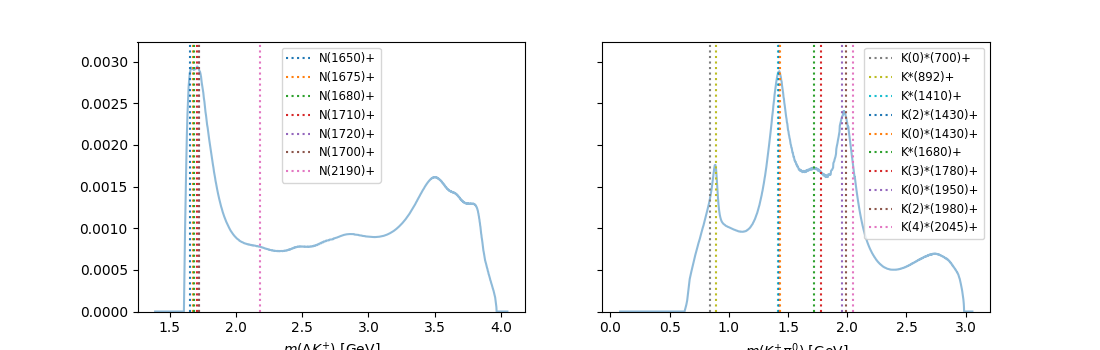

In [25]:
fig, axes = plt.subplots(figsize=(11, 3.5), ncols=2, sharey=True)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax1, ax2 = axes

for ax in axes:
    recoil_id = 3 if ax is ax1 else 1
    decay_products = sorted(set(reaction.final_state) - {recoil_id})
    product_latex = " ".join([reaction.final_state[i].latex for i in decay_products])
    ax.set_xlabel(f"$m({product_latex})$ [GeV]")

LINES = defaultdict(lambda: None)
RESONANCE_LINE = defaultdict(lambda: None)


def update_plot(**parameters):
    parameters = insert_phi(parameters)
    intensity_func.update_parameters(parameters)
    intensities = intensity_func(dalitz_data)  # z
    intensities /= jnp.nansum(intensities)  # normalization

    max_value = 0
    color_id = 0
    for ax in axes:
        if ax is ax1:
            x = jnp.sqrt(X[0])
            y = jnp.nansum(intensities, axis=0)
        else:
            x = jnp.sqrt(Y[:, 0])
            y = jnp.nansum(intensities, axis=1)

        max_value = max(max_value, y.max())
        recoil_id = 3 if ax is ax1 else 1
        if LINES[recoil_id] is None:
            LINES[recoil_id] = ax.plot(x, y, alpha=0.5)[0]
        else:
            LINES[recoil_id].set_ydata(y)

        for resonance in resonances[recoil_id]:
            key = f"m_{{{resonance.latex}}}"
            val = parameters.get(key, resonance.mass)
            if RESONANCE_LINE[color_id] is None:
                RESONANCE_LINE[color_id] = ax.axvline(
                    val,
                    c=f"C{color_id}",
                    ls="dotted",
                    label=resonance.name,
                )
            else:
                RESONANCE_LINE[color_id].set_xdata([val, val])
            color_id += 1

    for ax in axes:
        ax.set_ylim(0, max_value * 1.1)

    fig.canvas.draw()


w.interactive_output(update_plot, sliders)
for ax in axes:
    ax.legend(fontsize="small")

if STATIC_PAGE:
    filename = "histogram-dpd.svg"
    fig.savefig(filename)
    plt.close(fig)
    display(UI, SVG(filename))
else:
    display(UI, fig.canvas)